In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now

In [2]:
#import data
creep_df = pd.read_csv('../PI_Data/PI_Ni_superalloys_dataset.csv')

# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep life'])
creep_df = creep_df.drop(['Creep life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature,log_creep_life
0,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1100.0,137.0,944.638367,3.026370
1,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796,3.009026
2,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796,2.969556
3,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677,2.957607
4,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655,2.939519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644,1.155336
148,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381,1.089905
149,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902,0.991226
150,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101,0.968483


In [3]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ni                152 non-null    float32
 1   Al                152 non-null    float32
 2   Co                152 non-null    float32
 3   Cr                152 non-null    float32
 4   Mo                152 non-null    float32
 5   Re                152 non-null    float32
 6   Ru                152 non-null    float32
 7   Ta                152 non-null    float32
 8   W                 152 non-null    float32
 9   Ti                152 non-null    float32
 10  Nb                152 non-null    float32
 11  T                 152 non-null    float32
 12  Stress            152 non-null    float32
 13  PI Creep Feature  152 non-null    float32
 14  log_creep_life    152 non-null    float32
dtypes: float32(15)
memory usage: 9.0 KB


In [4]:
# Extract features and targets
features = creep_df.iloc[:, 0:14]
targets = creep_df.iloc[:, 14]
features

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature
0,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,272.0,8.275208
1,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101
2,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902
3,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381
4,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655
148,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677
149,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796
150,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796


In [5]:
# rmse loss
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Run # 1 Fold # 1


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:00:29.201374


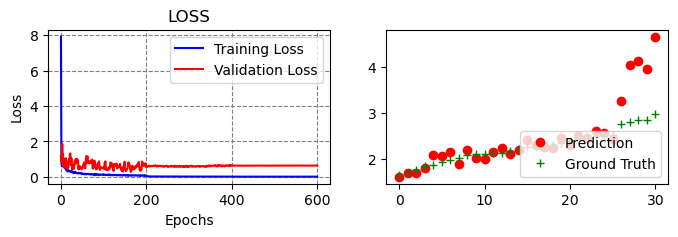

Pearson CC: 0.8982757168884059
R2 score: -1.1016955567975764
RMSE: 0.49635112285614014
MAE: 0.5762916207313538
********************
Run # 1 Fold # 2


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:00:27.906345


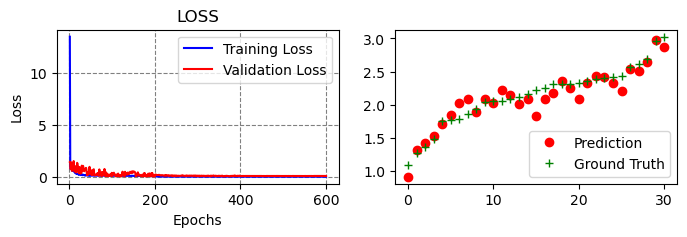

Pearson CC: 0.9558273463189786
R2 score: 0.9079988937281535
RMSE: 0.1349073052406311
MAE: 0.4807405173778534
********************
Run # 1 Fold # 3


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:00:32.142188


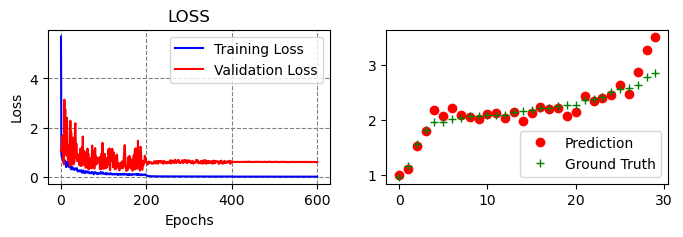

Pearson CC: 0.9416588292811847
R2 score: 0.7977752854561884
RMSE: 0.1802925318479538
MAE: 0.4606502950191498
********************
Run # 1 Fold # 4


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:00:31.349131


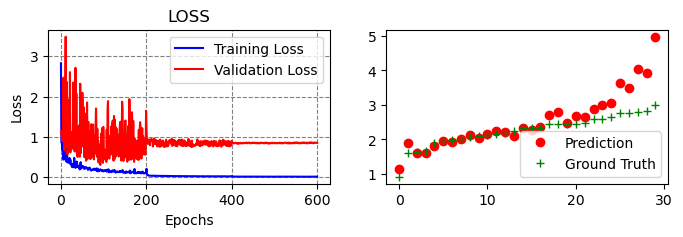

Pearson CC: 0.891981390593827
R2 score: -0.5411124345904303
RMSE: 0.5408393740653992
MAE: 0.7098748683929443
********************
Run # 1 Fold # 5


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:00:30.925355


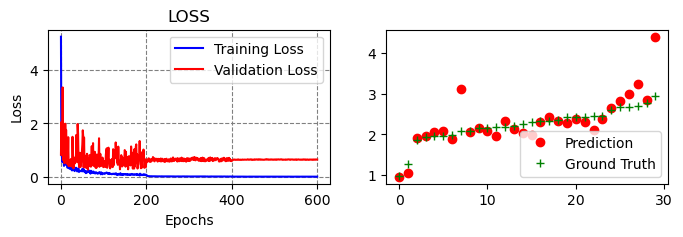

Pearson CC: 0.832745332769768
R2 score: 0.12230747241359297
RMSE: 0.36899545788764954
MAE: 0.5276784896850586
********************


In [6]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(14,)))
            model.add(Dense(1000,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))

            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [7]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.898276,-1.101696,0.496351,0.576292
1,0.955827,0.907999,0.134907,0.480741
2,0.941659,0.797775,0.180293,0.460650
3,0.891981,-0.541112,0.540839,0.709875
4,0.832745,0.122307,0.368995,0.527678


In [8]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.904098,0.043264,0.037055,0.771432,0.344277,0.163157,0.551047,0.088909
